In [1]:
%reset -s -f

In [26]:
import os
from functools import partial
import logging

import numpy as np
from numpy.random import binomial
from numpy.random import normal

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch 
from torch import nn
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.nn import PyroSample
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI
from pyro.infer import Trace_ELBO
from pyro.infer import Predictive
from pyro.infer import MCMC
from pyro.infer import NUTS

In [3]:
%matplotlib inline

In [4]:
assert pyro.__version__.startswith('1.3')
pyro.enable_validation(True)
pyro.set_rng_seed(42)
pyro.enable_validation(True)


### Generate a set of randomly distributed features

In [5]:
y = normal(0.7, 0.2, 1000)

In [6]:
# lets create an artificial dataset from randomly sampled points
data_df = pd.DataFrame({"F1": binomial(1, 0.1, 1000), 
                       "F2": binomial(1, 0.2, 1000),
                        "F3": binomial(1, 0.1, 1000),
                       "F4": binomial(1, 0.3, 1000), 
                       "F5": binomial(1, 0.5, 1000),
                       "F6": binomial(1, 0.2, 1000), 
                       "F7": binomial(1, 0.3, 1000),
                       "F8": binomial(1, 0.5, 1000),
                       "F9": binomial(1, 0.1, 1000),
                       "F10": binomial(1, 0.1, 1000),
                       "EXPLAIN": y})
data_df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,EXPLAIN
0,0,0,0,0,0,0,0,1,0,0,0.799343
1,0,0,0,0,1,0,0,1,0,0,0.672347
2,0,0,0,0,0,0,0,0,1,0,0.829538
3,0,0,0,0,0,0,0,1,0,0,1.004606
4,0,1,0,0,1,0,0,1,0,1,0.653169
...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,0,0,1,0,0,0.643780
996,0,0,0,0,1,0,0,1,0,0,1.059537
997,0,0,1,0,0,0,0,1,0,0,0.828169
998,0,1,0,1,1,0,1,1,0,0,0.585764


In [7]:
# make categorical data plottable
melted_df = pd.melt(data_df, id_vars="EXPLAIN")
melted_df = melted_df[melted_df["value"] != 0][["EXPLAIN", "variable"]]

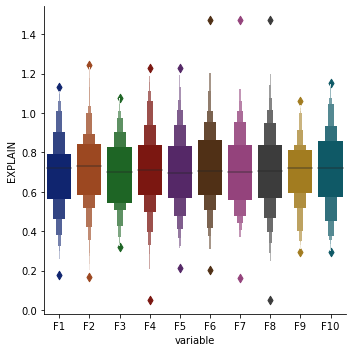

In [8]:
sns.catplot(x="variable", y="EXPLAIN", kind="boxen", palette="dark",
            data=melted_df)

In [9]:
# make the data PyTorch objects
X = torch.tensor(data_df[["F{}".format(i+1) for i in range(10)]].values, dtype=torch.float)
y = torch.tensor(data_df.EXPLAIN.values, dtype=torch.float)

INPUT_DIM = 10
OUTPUT_DIM = 1
ITERATIONS = 1500

X

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.]])

In [10]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0.,1.)
                                         .expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.)
                                      .expand([out_features]).to_event(1))
    
    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [11]:
# instantiate leaerning objects
bayes_reg_model = BayesianRegression(INPUT_DIM, OUTPUT_DIM)
guide = AutoDiagonalNormal(bayes_reg_model)

adam_opt = pyro.optim.Adam({"lr": 0.03})
svi = SVI(bayes_reg_model, guide, adam_opt, loss=Trace_ELBO())

In [12]:
pyro.clear_param_store()
for i in range(ITERATIONS):
    # make inference step
    loss = svi.step(X, y)
    # observe testing
    if i % 100 == 0:
        print("[iteration {}] loss: {}".format(i, loss / len(X)))

[iteration 0] loss: 3.278953137278557
[iteration 100] loss: 1.8395739648342133
[iteration 200] loss: -0.10384397792816162
[iteration 300] loss: -0.15536775732040406
[iteration 400] loss: -0.15713858342170714
[iteration 500] loss: -0.1551352195739746
[iteration 600] loss: -0.14897570419311523
[iteration 700] loss: -0.15510943937301636
[iteration 800] loss: -0.1568317747116089
[iteration 900] loss: -0.14908217906951904
[iteration 1000] loss: -0.16141310334205627
[iteration 1100] loss: -0.15414558887481689
[iteration 1200] loss: -0.15185554146766664
[iteration 1300] loss: -0.15520715045928954
[iteration 1400] loss: -0.15263343834877013


In [13]:
# inspect learned parameters
guide.requires_grad_(False)
print("Learned parameters:")
for name, param in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
print("Guide parameters:")
print(guide.quantiles([0.25, 0.5, 0.75]))

Learned parameters:
AutoDiagonalNormal.loc Parameter containing:
tensor([-3.9151e+00, -1.1454e-02,  1.1648e-02, -2.2069e-02,  2.4282e-02,
         2.9107e-03,  3.6307e-02,  1.0355e-03, -4.7750e-03,  3.8911e-03,
         1.0372e-03,  6.9383e-01])
AutoDiagonalNormal.scale tensor([0.0214, 0.0165, 0.0160, 0.0222, 0.0116, 0.0088, 0.0125, 0.0114, 0.0081,
        0.0216, 0.0214, 0.0061])
Guide parameters:
{'sigma': [tensor(0.1927), tensor(0.1955), tensor(0.1983)], 'linear.weight': [tensor([[-0.0226,  0.0009, -0.0370,  0.0165, -0.0030,  0.0279, -0.0066, -0.0102,
         -0.0106, -0.0134]]), tensor([[-0.0115,  0.0116, -0.0221,  0.0243,  0.0029,  0.0363,  0.0010, -0.0048,
          0.0039,  0.0010]]), tensor([[-0.0003,  0.0224, -0.0071,  0.0321,  0.0088,  0.0447,  0.0087,  0.0007,
          0.0184,  0.0154]])], 'linear.bias': [tensor([0.6897]), tensor([0.6938]), tensor([0.6979])]}


In [14]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v,0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


In [15]:
predict = Predictive(bayes_reg_model, guide=guide, num_samples=800,
                    return_sites=("linear.weight", "obs", "_RETURN"))
samples = predict(X)
pred_summary = summary(samples)

In [16]:
mu = pred_summary["_RETURN"]
y_hat = pred_summary["obs"]
predictions = pd.DataFrame({
    "F1": data_df.F1,
    "F2": data_df.F2,
    "F3": data_df.F3,
    "F4": data_df.F4,
    "F5": data_df.F5,
    "F6": data_df.F6,
    "F7": data_df.F7,
    "F8": data_df.F8,
    "F9": data_df.F9,
    "F10": data_df.F10,
    "mu_mean": mu["mean"],
    "mu_p95": mu["95%"],
    "mu_p5": mu["5%"],
    "y_mean": y_hat["mean"],
    "y_p95": y_hat["95%"],
    "y_p5": y_hat["5%"],
    "Y": y,
})
predictions

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,mu_mean,mu_p95,mu_p5,y_mean,y_p95,y_p5,Y
0,0,0,0,0,0,0,0,1,0,0,0.690068,0.707027,0.673036,0.684909,1.002709,0.382020,0.799343
1,0,0,0,0,1,0,0,1,0,0,0.692584,0.714328,0.669887,0.681588,1.007880,0.364762,0.672347
2,0,0,0,0,0,0,0,0,1,0,0.697690,0.733249,0.661211,0.697982,1.000050,0.390381,0.829538
3,0,0,0,0,0,0,0,1,0,0,0.690068,0.707027,0.673036,0.695463,0.998649,0.391991,1.004606
4,0,1,0,0,1,0,0,1,0,1,0.705946,0.752596,0.659359,0.718946,1.056015,0.386416,0.653169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,0,0,1,0,0,0.700848,0.732471,0.670753,0.706360,1.036105,0.386660,0.643780
996,0,0,0,0,1,0,0,1,0,0,0.692584,0.714328,0.669887,0.697407,1.022373,0.377828,1.059537
997,0,0,1,0,0,0,0,1,0,0,0.667512,0.707727,0.627507,0.664679,0.971336,0.349156,0.828169
998,0,1,0,1,1,0,1,1,0,0,0.729266,0.771362,0.686690,0.736550,1.068425,0.394582,0.585764


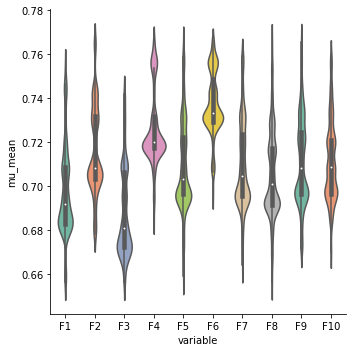

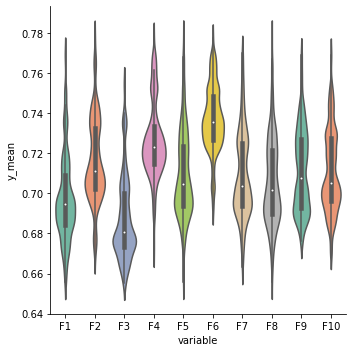

In [17]:
melted_pred = pd.melt(predictions, id_vars=["mu_mean", "y_mean", "Y"], 
        value_vars=["F{}".format(i+1) for i in range(10)])
melted_mu_pred_df = melted_pred[melted_pred["value"] != 0][["mu_mean", "variable"]]
melted_y_pred_df = melted_pred[melted_pred["value"] != 0][["y_mean", "variable"]]

sns.catplot(x="variable", y="mu_mean", kind="violin", bw=.2, palette="Set2", data=melted_mu_pred_df)
sns.catplot(x="variable", y="y_mean", kind="violin", bw=.2, palette="Set2", data=melted_y_pred_df)

Text(0.5, 0.98, 'Density of Fit')

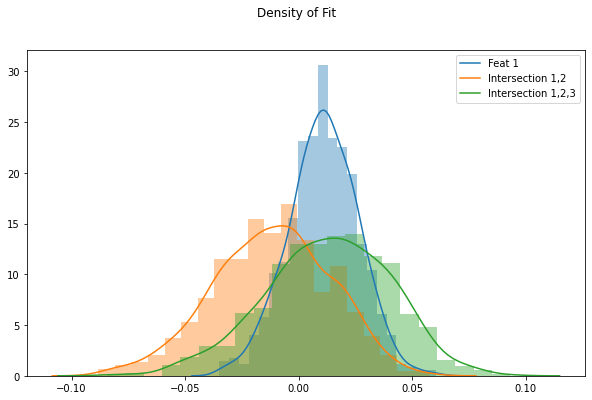

In [18]:
# plot uncertainty
weights = samples["linear.weight"]
weights = weights.reshape(weights.shape[0], 10)
gamma_1 = weights[:, 1]
gamma_12 = weights[:,1] + weights[:, 2]
gamma_123 = weights[:,1] + weights[:, 2] + weights[:, 3]

fig = plt.figure(figsize=(10,6))
sns.distplot(gamma_1, kde_kws={"label": "Feat 1"})
sns.distplot(gamma_12, kde_kws={"label": "Intersection 1,2"})
sns.distplot(gamma_123, kde_kws={"label": "Intersection 1,2,3"})
fig.suptitle("Density of Fit")

## Let's make the inference more explicit

In [19]:
# write model without PyroModule usage
def model(F1, F2, F3, EXPLAIN):
    """
    Model to take into account F1-3 and their interaction with explicit priors.
    """
    assert len(F1) == len(F2) == len(F3) == len(EXPLAIN)
    f = pyro.sample("f", dist.Normal(0., 10.))
    b_f1 = pyro.sample("bF1", dist.Normal(0., 1.))
    b_f2 = pyro.sample("bF2", dist.Normal(0., 1.))
    b_f3 = pyro.sample("bF3", dist.Normal(0., 1.))
    b_f12 = pyro.sample("bF12", dist.Normal(0., 1.))
    b_f13 = pyro.sample("bF13", dist.Normal(0., 1.))
    b_f23 = pyro.sample("bF23", dist.Normal(0., 1.))
    b_f123 = pyro.sample("bF123", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = f + b_f1*F1 + b_f2*F2 + b_f3*F3 + b_f12*F1*F2 + b_f13*F1*F3 + b_f23*F2*F3 + b_f123*F1*F2*F3
    # step over independent events
    with pyro.plate("data", len(F1)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=EXPLAIN)
        
def guide(F1, F2, F3, EXPLAIN):
    f_loc = pyro.param("f_loc", torch.tensor(0.))
    f_scale = pyro.param("f_scale", torch.tensor(1.), 
                        constraint=constraints.positive)
    sigma_loc = pyro.param("sigma_loc", torch.tensor(1.), 
                        constraint=constraints.positive)
    weights_loc = pyro.param("weights_loc", torch.randn(7))
    weights_scale = pyro.param("weights_scale", torch.ones(7),
                              constraint=constraints.positive)
    
    f = pyro.sample("f", dist.Normal(f_loc, f_scale))
    b_f1 = pyro.sample("bF1", dist.Normal(weights_loc[0], weights_scale[0]))
    b_f2 = pyro.sample("bF2", dist.Normal(weights_loc[1], weights_scale[1]))
    b_f3 = pyro.sample("bF3", dist.Normal(weights_loc[2], weights_scale[2]))
    b_f12 = pyro.sample("bF12", dist.Normal(weights_loc[3], weights_scale[3]))
    b_f13 = pyro.sample("bF13", dist.Normal(weights_loc[4], weights_scale[4]))
    b_f23 = pyro.sample("bF23", dist.Normal(weights_loc[5], weights_scale[5]))
    b_f123 = pyro.sample("bF123", dist.Normal(weights_loc[6], weights_scale[6]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = f + b_f1*F1 + b_f2*F2 + b_f3*F3 + b_f12*F1*F2 + b_f13*F1*F3 + b_f23*F2*F3 + b_f123*F1*F2*F3
    
    

In [20]:
def summary(samples):
    """
    Utility function to summarise the fit
    """
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

### Do SVI Inference

In [21]:
svi = SVI(model, guide, optim.Adam({'lr': 0.05}), loss=Trace_ELBO())

f1, f2, f3 = X[:,1], X[:,2], X[:,3]

pyro.clear_param_store()
ITERATION = 500

for i in range(ITERATIONS):
    elbo = svi.step(f1, f2, f3, y)
    if i % 100 == 0:
        print("[STEP {}] Elbo loss: {}".format(i, elbo))

[STEP 0] Elbo loss: 1378.9628422260284
[STEP 100] Elbo loss: 4.646309196949005
[STEP 200] Elbo loss: -89.8247155547142
[STEP 300] Elbo loss: -164.01889669895172
[STEP 400] Elbo loss: -87.26820284128189
[STEP 500] Elbo loss: -133.5522536635399
[STEP 600] Elbo loss: -31.366473257541656
[STEP 700] Elbo loss: -114.27435320615768
[STEP 800] Elbo loss: -144.1252020597458
[STEP 900] Elbo loss: -139.85303264856339
[STEP 1000] Elbo loss: -179.66637605428696
[STEP 1100] Elbo loss: -155.74272859096527
[STEP 1200] Elbo loss: -99.63542085886002
[STEP 1300] Elbo loss: -144.1758400797844
[STEP 1400] Elbo loss: -103.02821826934814


In [25]:
# predictive sampling from fit
num_samples = 1000
predict = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
              for k, v in predict(EXPLAIN=y, F1=f1, F2=f2, F3=f3).items() if k!="obs"}

for site, values in summary(svi_samples).items():
    print("\nSite {}".format(site))
    print(values)


Site f
       mean       std        5%       25%       50%       75%       95%
0  0.762546  0.008679  0.748184  0.756338  0.762795  0.768623  0.776214

Site bF1
       mean       std        5%       25%       50%       75%       95%
0  0.085267  0.015067  0.060259  0.075508  0.085082  0.094847  0.110499

Site bF2
       mean       std        5%       25%       50%     75%       95%
0  0.001496  0.016054 -0.024887 -0.009665  0.001635  0.0122  0.027859

Site bF3
       mean       std        5%       25%      50%       75%       95%
0  0.069693  0.012098  0.050833  0.061553  0.06942  0.076727  0.089977

Site bF12
       mean       std        5%       25%       50%       75%       95%
0 -0.011828  0.047498 -0.092941 -0.044025 -0.010394  0.020964  0.065719

Site bF13
       mean       std        5%       25%       50%       75%       95%
0 -0.046657  0.022794 -0.084556 -0.061082 -0.046932 -0.031568 -0.010445

Site bF23
       mean       std        5%       25%       50%       75%       95%

### Do MCMC Inference

In [27]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=200)
mcmc.run(f1, f2, f3, y)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [01:55, 10.42it/s, step size=3.67e-01, acc. prob=0.910]


In [28]:
for site, values in summaryahmc_samples_samples).items():
    print("\nSite {}".format(site))
    print(values)


Site f
       mean       std        5%       25%       50%       75%       95%
0  0.694133  0.008513  0.680738  0.688067  0.694011  0.699566  0.708602

Site bF1
       mean       std        5%       25%       50%       75%       95%
0  0.029086  0.019562 -0.002792  0.014913  0.028616  0.043186  0.059769

Site bF2
       mean       std        5%       25%       50%       75%       95%
0 -0.000589  0.026879 -0.045517 -0.018845 -0.000456  0.016889  0.044754

Site bF3
       mean       std        5%       25%       50%       75%       95%
0  0.027364  0.015065  0.002336  0.017144  0.026992  0.036896  0.052904

Site bF12
       mean       std        5%       25%       50%       75%       95%
0 -0.021737  0.058954 -0.115279 -0.061374 -0.021694  0.019335  0.075343

Site bF13
       mean       std        5%       25%       50%       75%       95%
0 -0.064701  0.037504 -0.126959 -0.091457 -0.065754 -0.038259 -0.003873

Site bF23
       mean       std        5%       25%       50%       75%    

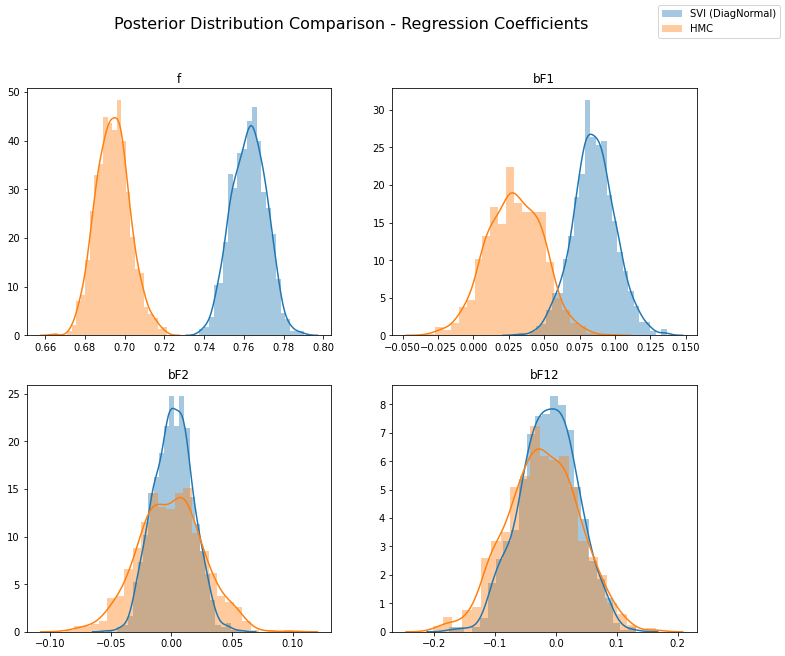

In [35]:
# compare posterior distributions
sites = ["f", "bF1", "bF2", "bF12", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
fig.suptitle("Posterior Distribution Comparison - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right");

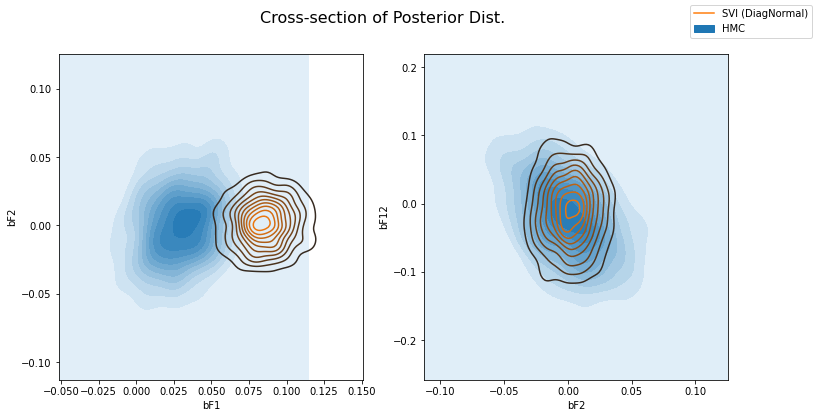

In [34]:
# compare densities of posterior distributions

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Cross-section of Posterior Dist.", fontsize=16)
sns.kdeplot(hmc_samples["bF1"], hmc_samples["bF2"], ax=axs[0],
           shade=True, label="HMC")
sns.kdeplot(svi_samples["bF1"], svi_samples["bF2"], ax=axs[0],
           label="SVI (DiagNormal)")
sns.kdeplot(hmc_samples["bF2"], hmc_samples["bF12"], ax=axs[1], 
           shade=True, label="HMC")
sns.kdeplot(svi_samples["bF2"], svi_samples["bF12"], ax=axs[1],
           label="SVI (DiagNormal)")
axs[0].set(xlabel="bF1", ylabel="bF2")
axs[1].set(xlabel="bF2", ylabel="bF12")
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right");